In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [15]:
df=pd.read_csv("/content/TSLA_historical_data.csv")

In [16]:
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,03-01-2012,1.929333,1.966667,1.843333,1.872000,1.872000,13921500
1,04-01-2012,1.880667,1.911333,1.833333,1.847333,1.847333,9451500
2,05-01-2012,1.850667,1.862000,1.790000,1.808000,1.808000,15082500
3,06-01-2012,1.813333,1.852667,1.760667,1.794000,1.794000,14794500
4,09-01-2012,1.800000,1.832667,1.741333,1.816667,1.816667,13455000


# **DATA PREPROCESSING AND EDA**

In [18]:
# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

# Set 'Date' as the index
df.set_index('Date', inplace=True)

#getting statistical info of data
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3018 entries, 2012-01-03 to 2023-12-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3018 non-null   float64
 1   High       3018 non-null   float64
 2   Low        3018 non-null   float64
 3   Close      3018 non-null   float64
 4   Adj Close  3018 non-null   float64
 5   Volume     3018 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 165.0 KB


,Open,High,Low,Close,Adj Close,Volume
count,3018.000000,3018.000000,3018.000000,3018.000000,3018.000000,3.018000e+03
mean,79.200165,80.946282,77.319941,79.178199,79.178199,1.064283e+08
std,104.619883,106.955932,102.046536,104.535965,104.535965,7.943636e+07
min,1.774667,1.790000,1.509333,1.519333,1.519333,5.473500e+06
25%,13.831500,14.051000,13.587000,13.818667,13.818667,5.802675e+07
50%,18.900333,19.239333,18.574666,18.954333,18.954333,8.896350e+07
75%,159.657497,161.569996,153.244999,159.730003,159.730003,1.305753e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,9.140820e+08


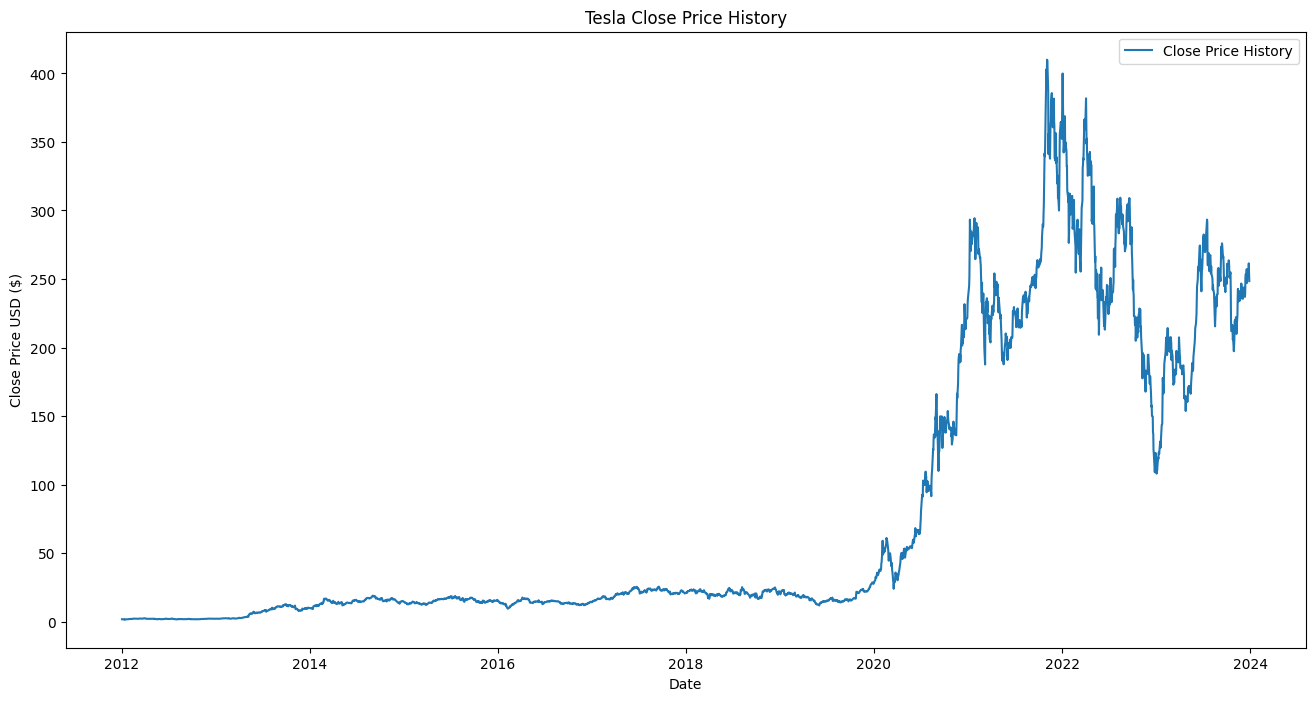

In [19]:
# Plot the closing price history
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price History')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.title('Tesla Close Price History')
plt.legend()
plt.show()

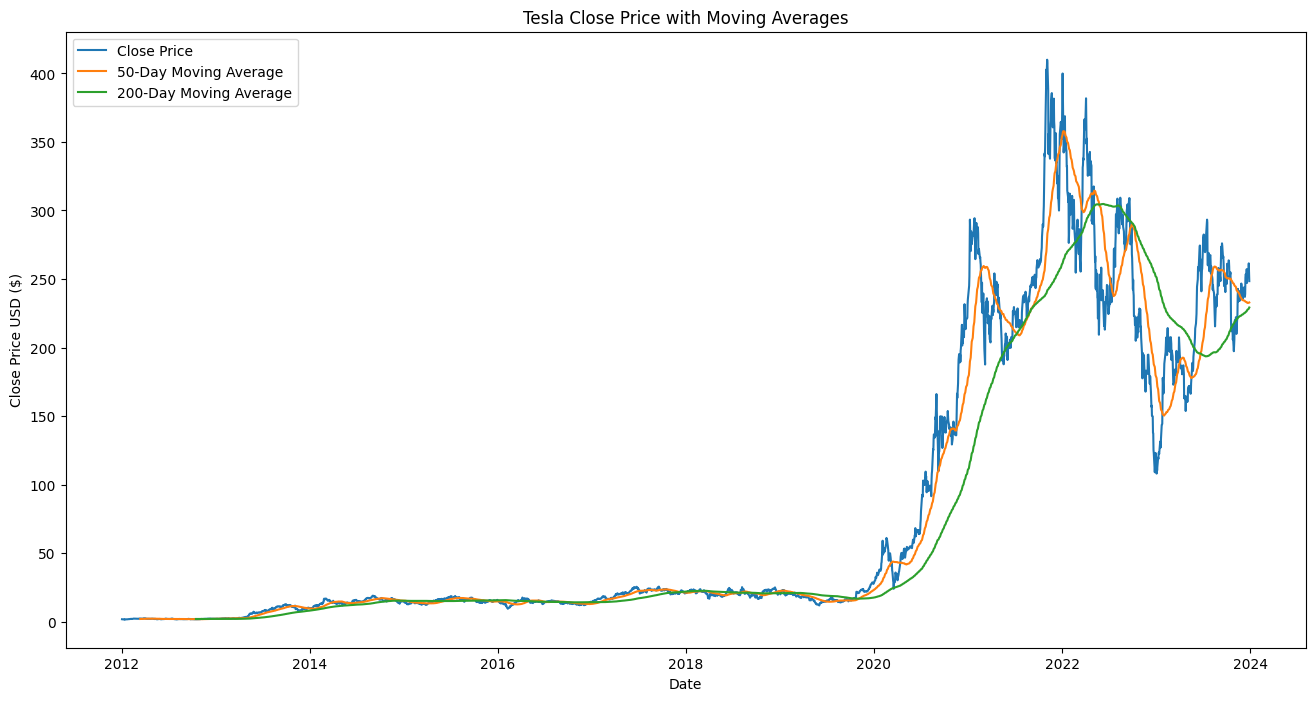

In [20]:
#plot moving averages
df['MA50'] = df['Close'].rolling(window=50).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()

plt.figure(figsize=(16, 8))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['MA50'], label='50-Day Moving Average')
plt.plot(df['MA200'], label='200-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.title('Tesla Close Price with Moving Averages')
plt.legend()
plt.show()


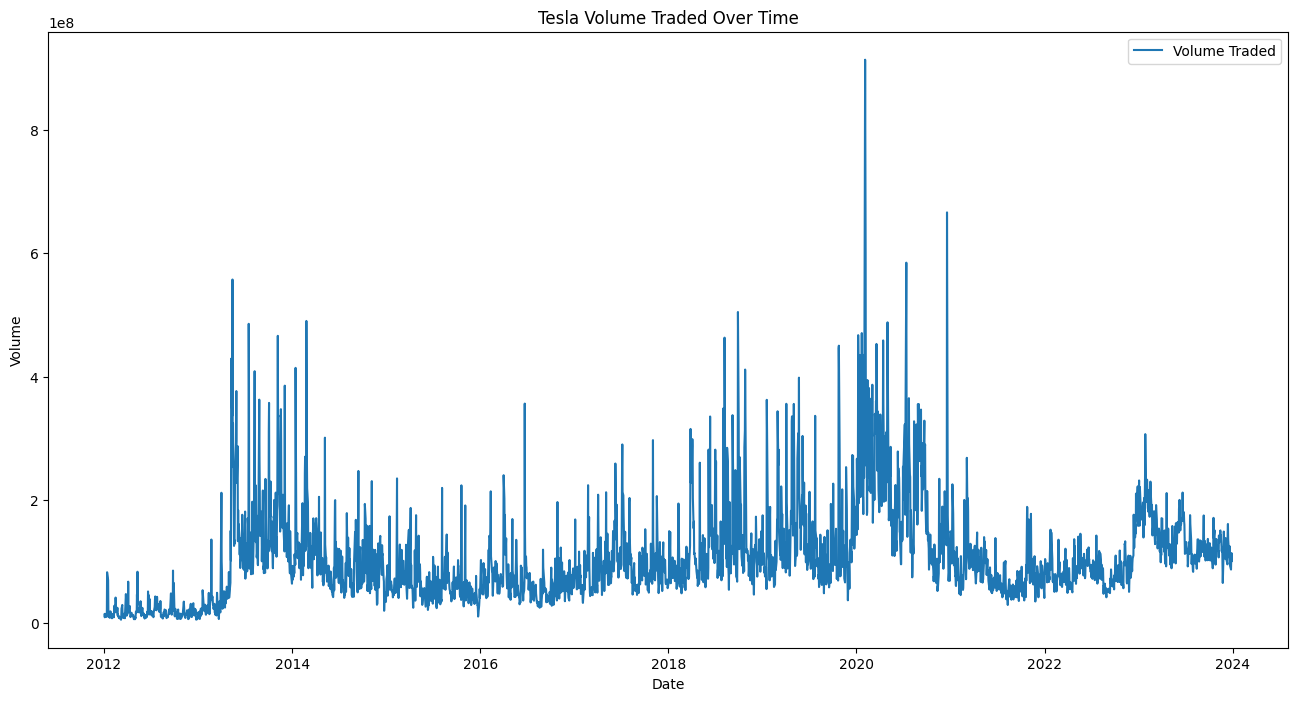

In [21]:
#volume traded over time
plt.figure(figsize=(16, 8))
plt.plot(df['Volume'], label='Volume Traded')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Tesla Volume Traded Over Time')
plt.legend()
plt.show()

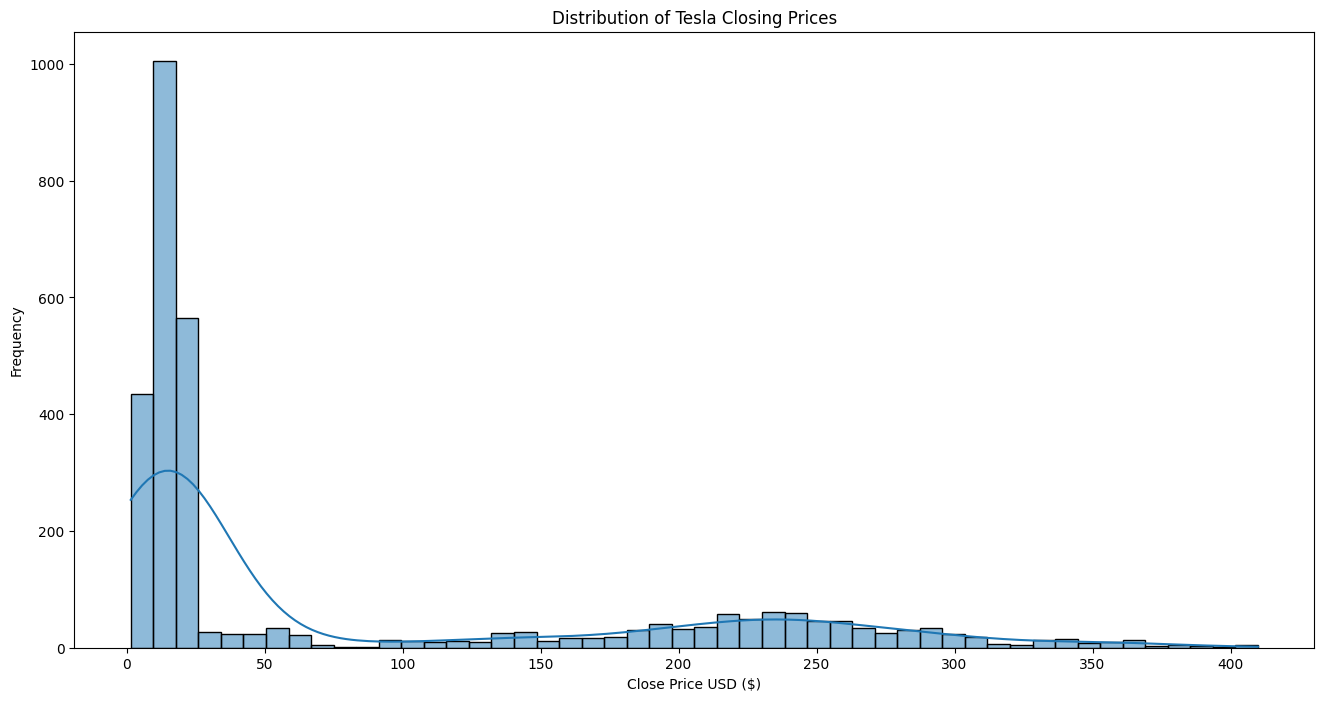

In [22]:
# Distribution of closing prices
plt.figure(figsize=(16, 8))
sns.histplot(df['Close'], bins=50, kde=True)
plt.xlabel('Close Price USD ($)')
plt.ylabel('Frequency')
plt.title('Distribution of Tesla Closing Prices')
plt.show()


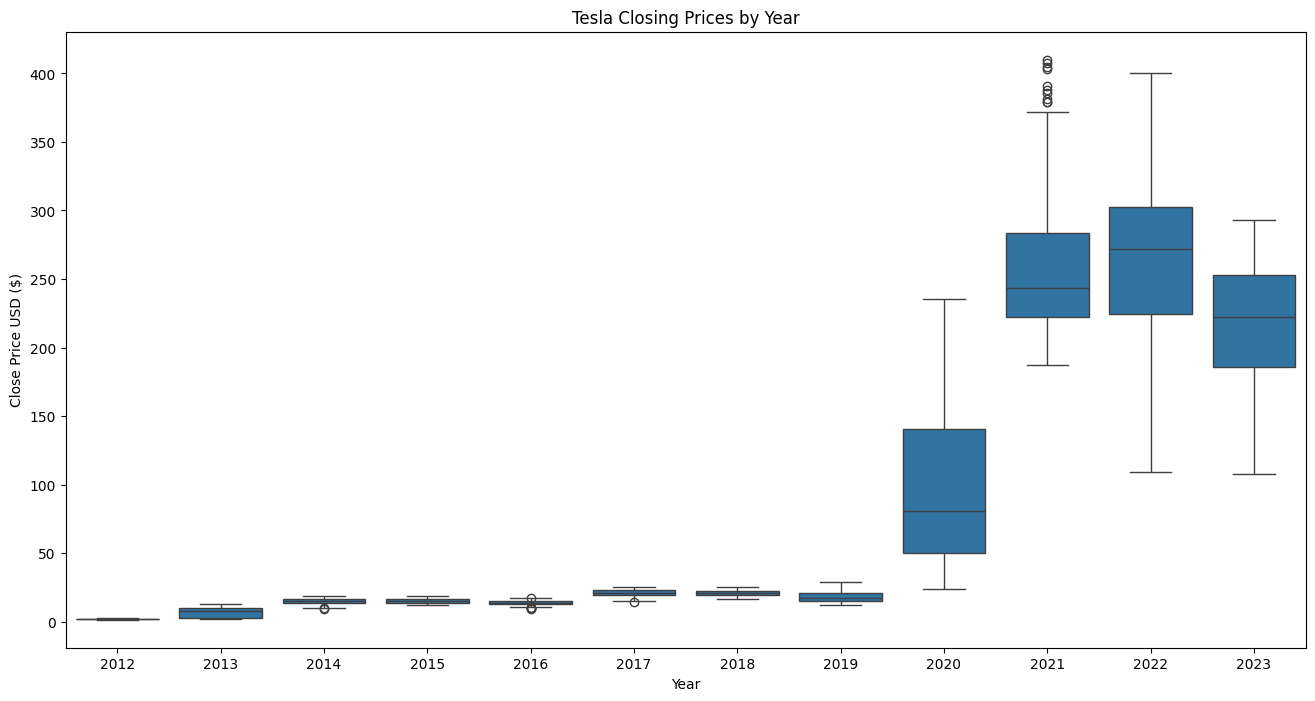

In [23]:
#Box plot of closing prices by year
df['Year'] = df.index.year

plt.figure(figsize=(16, 8))
sns.boxplot(x='Year', y='Close', data=df)
plt.xlabel('Year')
plt.ylabel('Close Price USD ($)')
plt.title('Tesla Closing Prices by Year')
plt.show()

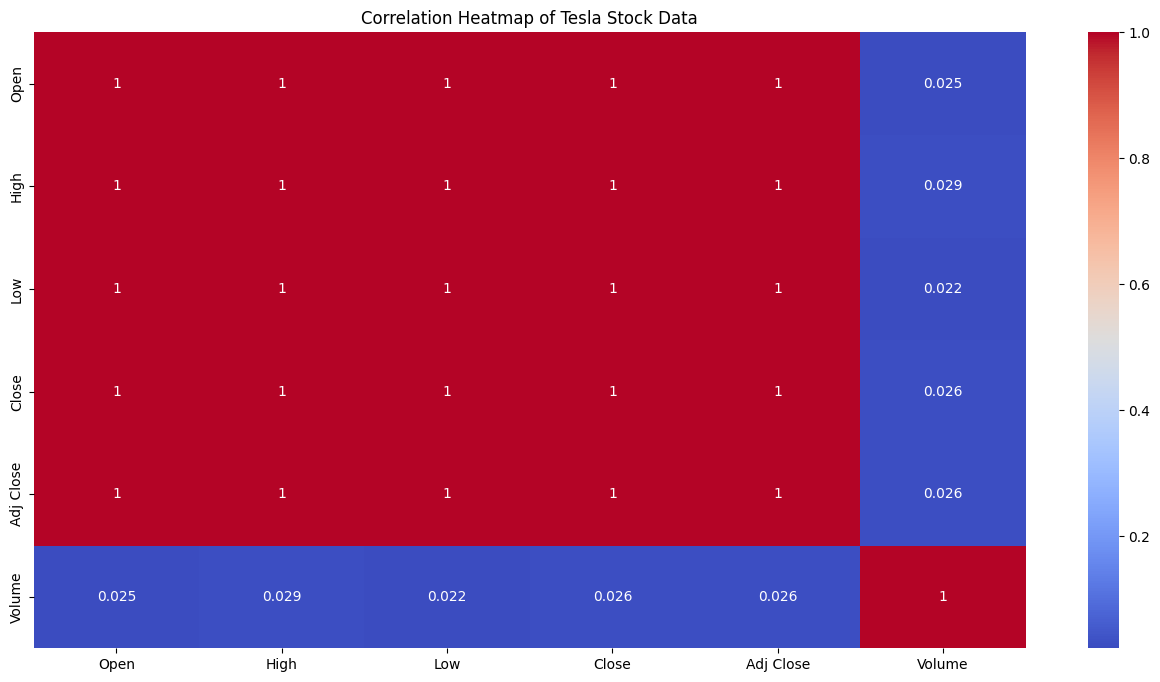

In [24]:
#correlation Heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Tesla Stock Data')
plt.show()

In [25]:
# Normalize the 'Close' column
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

# Split data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]


In [26]:
# Convert data to time-series format
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# **LSTM for Stock Prediction**

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [28]:
# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=1)

2353/2353 [==============================] - 79s 32ms/step - loss: 7.1786e-04


In [31]:
# Predict on test data
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Inverse transform the actual test values
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

17/17 [==============================] - 0s 26ms/step


In [35]:
# Ensure lengths match
valid = df[train_size + time_step + 1:]
valid['Predictions'] = predictions

<ipython-input-35-186f15aab854>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

In [33]:
# Inverse transform the actual test values
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate R-squared
r2 = r2_score(y_test_actual, predictions)

# Calculate MSE
mse = mean_squared_error(y_test_actual, predictions)

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test_actual, predictions)

# Print the R-squared value
print(f'R-squared: {r2}')

# Print the evaluation metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')


R-squared: 0.742942171684941
Mean Squared Error (MSE): 992.467637115564
Root Mean Squared Error (RMSE): 31.50345436798263
Mean Absolute Percentage Error (MAPE): 0.1130261507353121


<ipython-input-36-6604a0e552cd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


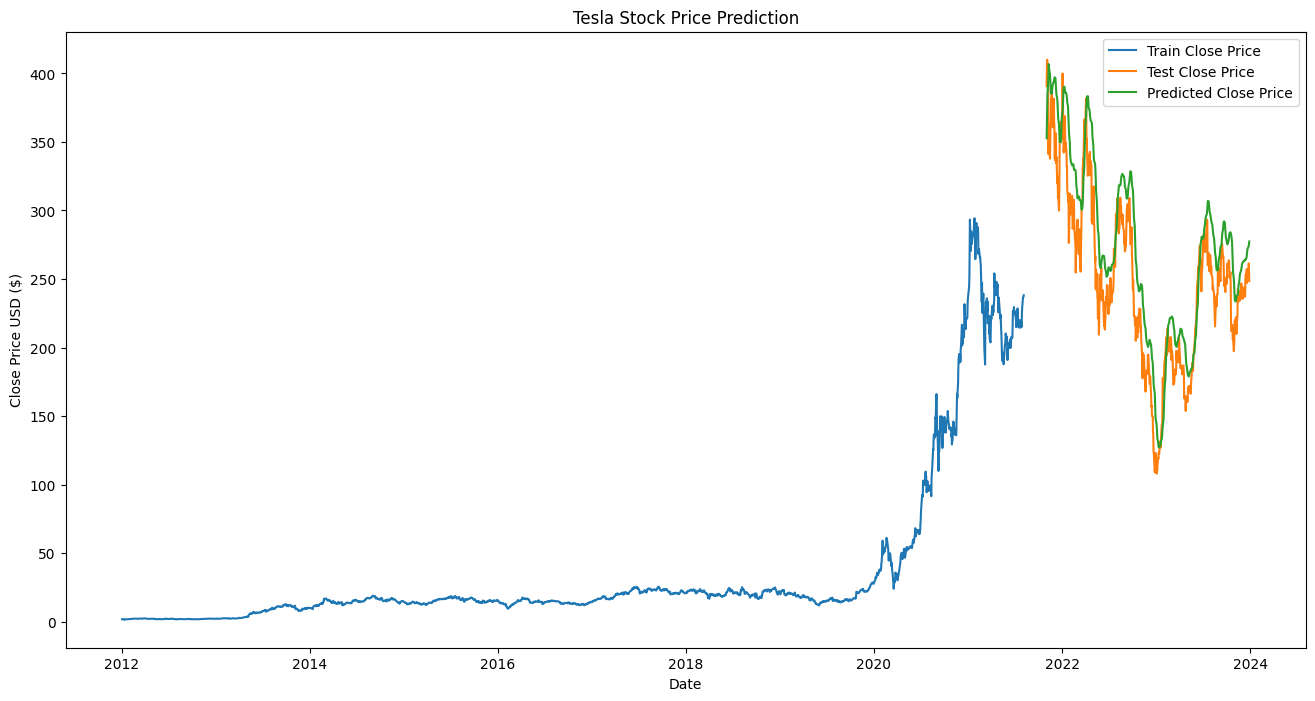

In [36]:
# Visualize the predictions
train = df[:train_size]
valid = df[train_size + time_step + 1:]
valid['Predictions'] = predictions

plt.figure(figsize=(16, 8))
plt.plot(train['Close'], label='Train Close Price')
plt.plot(valid['Close'], label='Test Close Price')
plt.plot(valid['Predictions'], label='Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.title('Tesla Stock Price Prediction')
plt.legend()
plt.show()

# **NEXT DAY  PREDICTION**

In [37]:
# Use the last 'time_step' days from the test data
last_time_step_data = test_data[-time_step:].reshape(1, time_step, 1)

# Predict the next day's closing price
next_day_prediction = model.predict(last_time_step_data)
next_day_prediction = scaler.inverse_transform(next_day_prediction)
print(f'Next Day Predicted Closing Price: {next_day_prediction[0][0]}')

1/1 [==============================] - 0s 44ms/step
Next Day Predicted Closing Price: 278.4072570800781


In [43]:
# Predict the next 30 days
future_predictions_month = []
last_time_step_data = test_data[-time_step:].reshape(1, time_step, 1)

for _ in range(30):
    next_day_prediction = model.predict(last_time_step_data)
    future_predictions_month.append(next_day_prediction[0][0])
    next_day_prediction = np.reshape(next_day_prediction, (1, 1, 1))
    last_time_step_data = np.append(last_time_step_data[:, 1:, :], next_day_prediction, axis=1)

# Inverse transform the predictions
future_predictions_month = scaler.inverse_transform(np.array(future_predictions_month).reshape(-1, 1))


1/1 [==============================] - 0s 23ms/step


In [44]:
# Predict the next 365 days
future_predictions_year = []
last_time_step_data = test_data[-time_step:].reshape(1, time_step, 1)

for _ in range(365):
    next_day_prediction = model.predict(last_time_step_data)
    future_predictions_year.append(next_day_prediction[0][0])
    next_day_prediction = np.reshape(next_day_prediction, (1, 1, 1))
    last_time_step_data = np.append(last_time_step_data[:, 1:, :], next_day_prediction, axis=1)

# Inverse transform the predictions
future_predictions_year = scaler.inverse_transform(np.array(future_predictions_year).reshape(-1, 1))


1/1 [==============================] - 0s 26ms/step


# **NEXT MONTH PREDICTION**

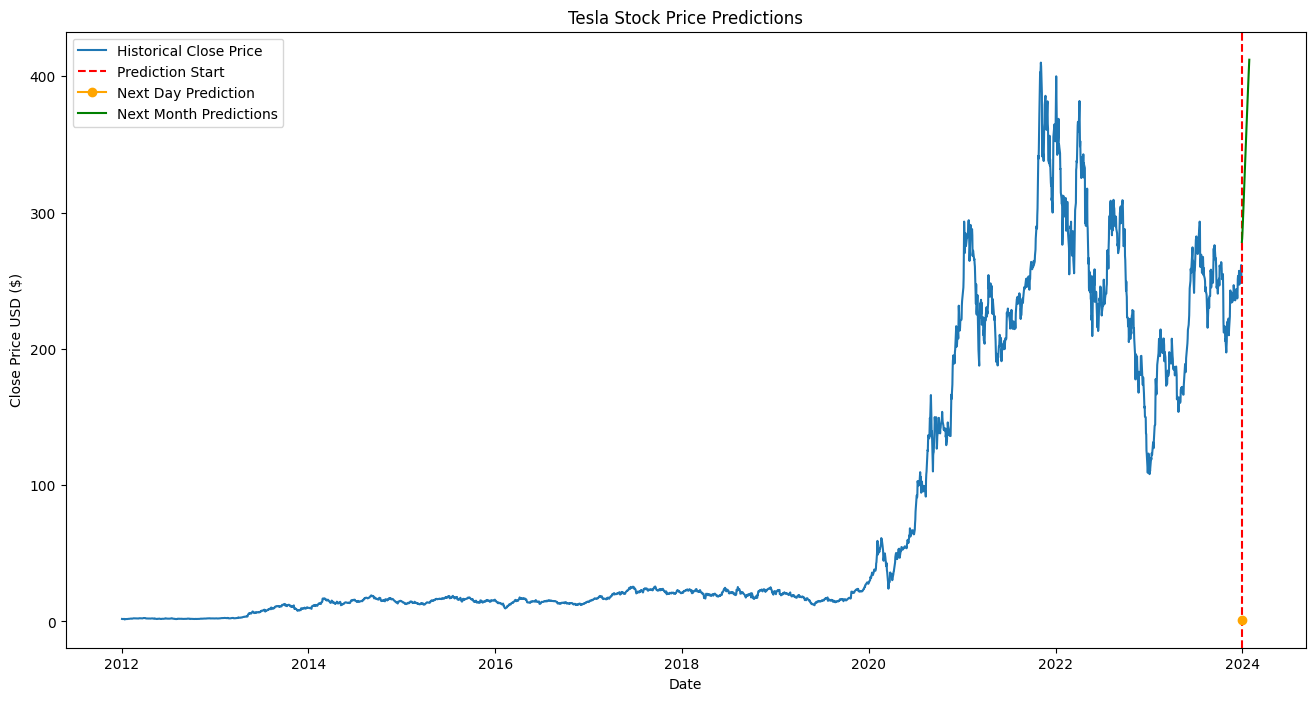

In [47]:
# Plotting future predictions
plt.figure(figsize=(16, 8))

# Plot historical data
plt.plot(df['Close'], label='Historical Close Price')

# Plot next day prediction
plt.axvline(x=df.index[-1], color='r', linestyle='--', label='Prediction Start')
plt.plot(pd.date_range(start=df.index[-1], periods=2, freq='D')[1:], [next_day_prediction[0][0]], label='Next Day Prediction', marker='o', color='orange')

# Plot next month predictions
plt.plot(pd.date_range(start=df.index[-1], periods=31, freq='D')[1:], future_predictions_month, label='Next Month Predictions', color='green')


plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.title('Tesla Stock Price Predictions')
plt.legend()
plt.show()


# **NEXT YEAR PREDICTION**

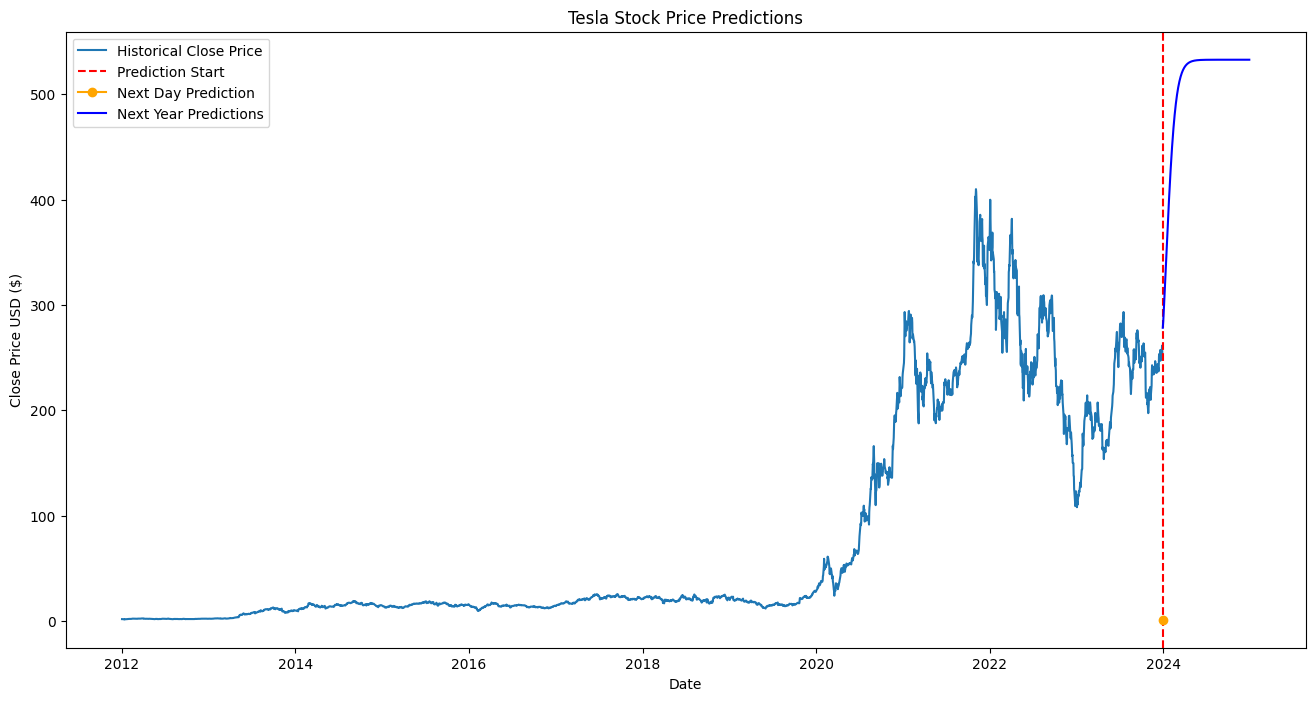

In [48]:
# Plotting future predictions
plt.figure(figsize=(16, 8))

# Plot historical data
plt.plot(df['Close'], label='Historical Close Price')

# Plot next day prediction
plt.axvline(x=df.index[-1], color='r', linestyle='--', label='Prediction Start')
plt.plot(pd.date_range(start=df.index[-1], periods=2, freq='D')[1:], [next_day_prediction[0][0]], label='Next Day Prediction', marker='o', color='orange')


# Plot next year predictions
plt.plot(pd.date_range(start=df.index[-1], periods=366, freq='D')[1:], future_predictions_year, label='Next Year Predictions', color='blue')

plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.title('Tesla Stock Price Predictions')
plt.legend()
plt.show()
